In [27]:
import sys
import numpy as np
import math

from tqdm import tqdm

import flory

sys.path.append('../..')
print(np.__version__)


import importlib

from scipy import cluster, spatial

from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution

#sys.path.append('/Users/calvinsmith/dufresne_lab/lab_work/llps_classification')
import flory_generate as gen
import flory_plots as plots
importlib.reload(gen)
importlib.reload(plots)

2.0.0


<module 'flory_plots' from '/Users/calvinsmith/dufresne_lab/lab_work/llps_classification/flory_plots.py'>

# Step Function, Loss Function, Readout Function

In [28]:
'''Goal Function '''
def step_func(x):
    if x >= 0.5:
        return 0
    elif 0 <= x < 0.5:
        return 1
    else: 
        raise Exception("Sorry, no numbers below zero")
'''Calculate the Loss'''
def calc_loss(points):
    loss = 0
    for point in points:
        loss += (step_func(point[0]) - point[1])**2
    return loss


def output_readout_func(phi_in, phi_out):
    x = math.exp(-(phi_in/phi_out))
    return x






# Main Function 
Takes phi_in_thresh, phi_out, phi_H, num_of_points, chi_strenght as parameters and returns a list of the most dilute phases from each point(dilute_comp_arr)


In [29]:
def evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength):
    num_comps = len(phi_H) + 2
    #generate chi_matrix
    chi_matrix = gen.chi_matrix_w_sol(num_comps,chi_strength)
    #generate comp_points
    print(chi_matrix)
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(0,phi_in_thresh, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = phi_out*np.ones((num_of_points,1))
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    #add solvent component
    phi_sol_points = []
    for phi_in in phi_in_points:
        phi_sol= 1 - (phi_in + phi_out + sum(phi_H)) 
        phi_sol_points.append(phi_sol)

    phi_sol_points = np.array(phi_sol_points)

    comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)

    evolved_comp_points = []
    for point in (comp_points):
        phase = flory.find_coexisting_phases(num_comps+1,chi_matrix,point, progress = False)
        evolved_comp_points.append(phase)

    dilute_comp_points = []
    for phase in evolved_comp_points:
        x = gen.most_dilute_flory(phase)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,output_readout_func)

    
    return dilute_out_comp_arr
    

    
            

# Wrapper Function
Wrapper function that only takes phi_H so we can use it in our optimization

In [30]:
def evolve_components_flory_loss(phi_H):
    phi_in_thresh = 0.2
    phi_H_thresh = 0.6
    phi_out = 0.1
    num_of_points = 6
    chi_strength = 6
    H_dim = 2
    readout_func = output_readout_func
    

    if gen.in_bounds(phi_H,phi_H_thresh):
        print("IN BOUNDS")
        results = evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength)
        output_comp_points = np.zeros((num_of_points,2))
        count = 0
        phi_init = np.linspace(0,1, num_of_points)
        for point in results:
            x = readout_func(point[0],point[-2])
            output_comp_points[count,:] = [phi_init[count],x]
            count+=1
        
        
        loss = calc_loss(output_comp_points)
        print(f"LOSS: {loss}")

        return loss
    else:
        #This is if it is out of bounds, supposed to disincentivize going out of bounds
        print("OUT OF BOUNDS")
        return 10000


# Optimization

OUT OF BOUNDS
IN BOUNDS
[[0.         5.34065479 4.20105852 5.55774831 4.10660907 7.41101298
  0.        ]
 [5.34065479 0.         5.28866995 5.12428077 5.80211293 7.44315976
  0.        ]
 [4.20105852 5.28866995 0.         4.96088496 7.94477239 6.41274831
  0.        ]
 [5.55774831 5.12428077 4.96088496 0.         4.58985981 7.44309084
  0.        ]
 [4.10660907 5.80211293 7.94477239 4.58985981 0.         7.9321636
  0.        ]
 [7.41101298 7.44315976 6.41274831 7.44309084 7.9321636  0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.24406146 0.04276988 0.04641521 0.0418746  0.1
  0.52487884]
 [0.04       0.24406146 0.04276988 0.04641521 0.0418746  0.1
  0.48487884]
 [0.08       0.24406146 0.04276988 0.04641521 0.0418746  0.1
  0.44487884]
 [0.12       0.24406146 0.04276988 0.04641521 0.0418746  0.1
  0.40487884]
 [0.16       0.24406146 0.04276988 0.04641521 0.0418746  0.1
  0.36487884]
 [0.2        0.24406146 0.04276988 0.046415

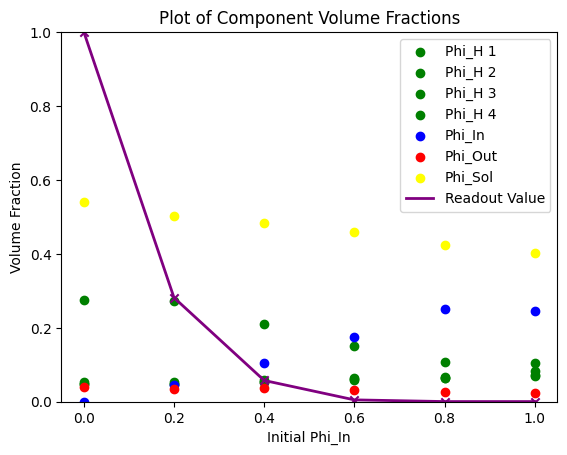

LOSS: 1.4056098144615379
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         5.6640507  6.04600195 6.17533043 5.81970931 4.84710978
  0.        ]
 [5.6640507  0.         4.49097521 5.87102393 5.29788127 4.35564668
  0.        ]
 [6.04600195 4.49097521 0.         7.95864724 5.4925935  7.51098421
  0.        ]
 [6.17533043 5.87102393 7.95864724 0.         5.12479295 7.31676137
  0.        ]
 [5.81970931 5.29788127 5.4925935  5.12479295 0.         6.43278869
  0.        ]
 [4.84710978 4.35564668 7.51098421 7.31676137 6.43278869 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.28123637 0.0554407  0.07908983 0.14030804 0.1
  0.34392507]
 [0.04       0.28123637 0.0554407  0.07908983 0.14030804 0.1
  0.30392507]
 [0.08       0.28123637 0.0554407  0.07908983 0.14030804 0.1
  0.26392507]
 [0.12       0.28123637 0.0554407  0.07908983 0.14030804 0.1
  0.22392507]
 [0.16       0.28123637 0.0554407  0.07908983 0.14030804 0.1
  0.18392507]
 [0

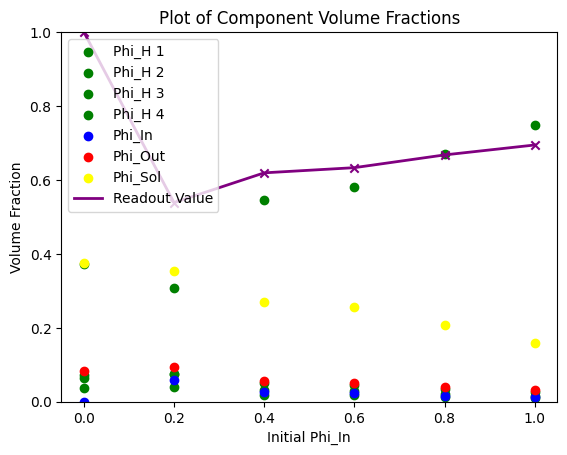

LOSS: 1.6862343661807377
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         5.35547397 5.44714932 7.35374397 4.88821129 6.5324412
  0.        ]
 [5.35547397 0.         5.47707473 6.70946642 5.84520549 5.33642155
  0.        ]
 [5.44714932 5.47707473 0.         6.72349187 4.29843695 6.09902405
  0.        ]
 [7.35374397 6.70946642 6.72349187 0.         5.84342981 5.59672794
  0.        ]
 [4.88821129 5.84520549 4.29843695 5.84342981 0.         7.47998304
  0.        ]
 [6.5324412  5.33642155 6.09902405 5.59672794 7.47998304 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.24406146 0.16209942 0.04641521 0.09249835 0.1
  0.35492556]
 [0.04       0.24406146 0.16209942 0.04641521 0.09249835 0.1
  0.31492556]
 [0.08       0.24406146 0.16209942 0.04641521 0.09249835 0.1
  0.27492556]
 [0.12       0.24406146 0.16209942 0.04641521 0.09249835 0.1
  0.23492556]
 [0.16       0.24406146 0.16209942 0.04641521 0.09249835 0.1
  0.

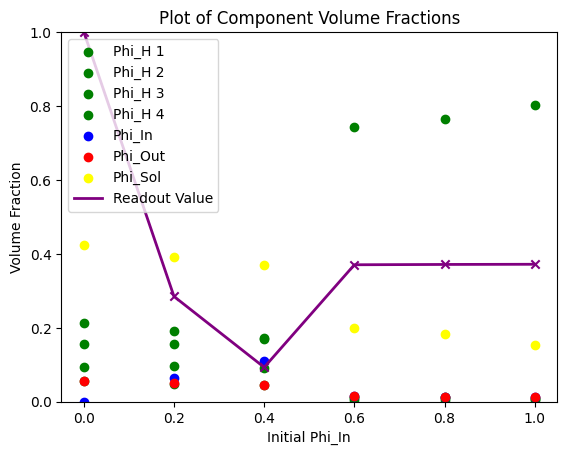

LOSS: 1.7478982420725868
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         6.16646614 7.34392006 5.70038022 7.24425121 6.83669554
  0.        ]
 [6.16646614 0.         6.57853438 7.24588075 5.27331085 5.54379801
  0.        ]
 [7.34392006 6.57853438 0.         5.46997076 4.94410302 4.79930077
  0.        ]
 [5.70038022 7.24588075 5.46997076 0.         6.1464343  7.4207363
  0.        ]
 [7.24425121 5.27331085 4.94410302 6.1464343  0.         3.826897
  0.        ]
 [6.83669554 5.54379801 4.79930077 7.4207363  3.826897   0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.06434628 0.14118494 0.10439844 0.0791598  0.1
  0.51091054]
 [0.04       0.06434628 0.14118494 0.10439844 0.0791598  0.1
  0.47091054]
 [0.08       0.06434628 0.14118494 0.10439844 0.0791598  0.1
  0.43091054]
 [0.12       0.06434628 0.14118494 0.10439844 0.0791598  0.1
  0.39091054]
 [0.16       0.06434628 0.14118494 0.10439844 0.0791598  0.1
  0.35091054]
 [0.2 

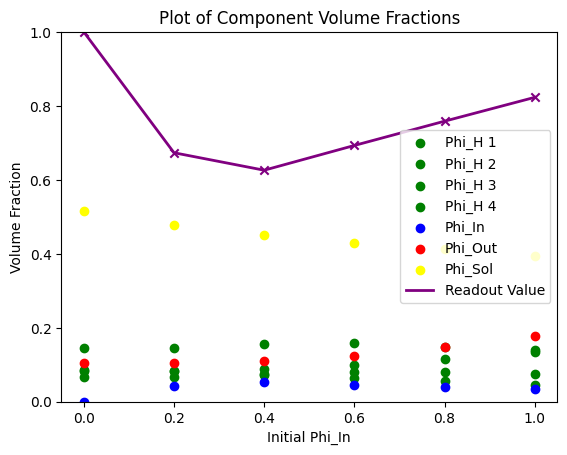

LOSS: 1.9799788463300692
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         6.31299237 6.93410389 6.52527879 6.57366878 8.43724834
  0.        ]
 [6.31299237 0.         4.94893792 6.05775641 4.64357624 6.93270756
  0.        ]
 [6.93410389 4.94893792 0.         4.77113344 5.52187022 5.86663845
  0.        ]
 [6.52527879 6.05775641 4.77113344 0.         6.18675351 5.3967834
  0.        ]
 [6.57366878 4.64357624 5.52187022 6.18675351 0.         6.77818118
  0.        ]
 [8.43724834 6.93270756 5.86663845 5.3967834  6.77818118 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.24406146 0.04276988 0.02628586 0.11099474 0.1
  0.47588806]
 [0.04       0.24406146 0.04276988 0.02628586 0.11099474 0.1
  0.43588806]
 [0.08       0.24406146 0.04276988 0.02628586 0.11099474 0.1
  0.39588806]
 [0.12       0.24406146 0.04276988 0.02628586 0.11099474 0.1
  0.35588806]
 [0.16       0.24406146 0.04276988 0.02628586 0.110

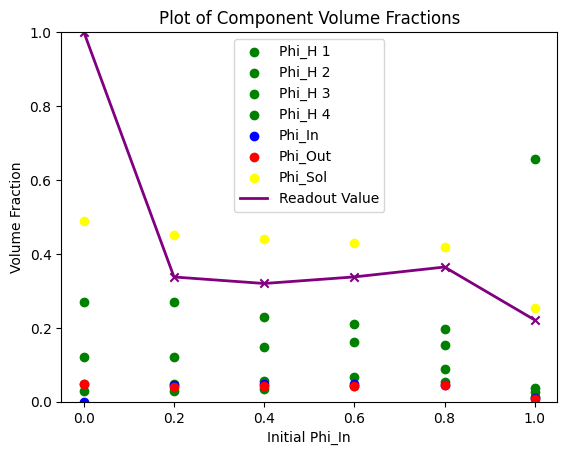

LOSS: 1.1975411773347973
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         6.04557772 6.298581   5.46924665 4.86675261 5.74961389
  0.        ]
 [6.04557772 0.         5.58628666 7.27329137 6.76181138 4.12452339
  0.        ]
 [6.298581   5.58628666 0.         7.09502066 6.85208859 5.96226298
  0.        ]
 [5.46924665 7.27329137 7.09502066 0.         6.76342586 6.18794579
  0.        ]
 [4.86675261 6.76181138 6.85208859 6.76342586 0.         5.47992664
  0.        ]
 [5.74961389 4.12452339 5.96226298 6.18794579 5.47992664 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.06434628 0.11676145 0.09888377 0.0791598  0.1
  0.5408487 ]
 [0.04       0.06434628 0.11676145 0.09888377 0.0791598  0.1
  0.5008487 ]
 [0.08       0.06434628 0.11676145 0.09888377 0.0791598  0.1
  0.4608487 ]
 [0.12       0.06434628 0.11676145 0.09888377 0.0791598  0.1
  0.4208487 ]
 [0.16       0.06434628 0.11676145 0.09888377 0.0791598  0.1
  0.3808487 ]
 [0

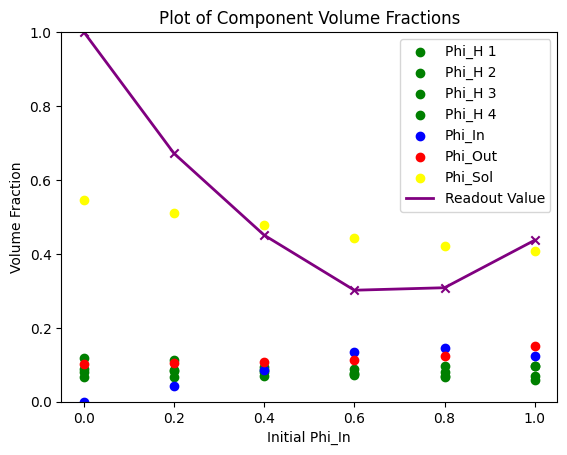

LOSS: 0.7864980914824923
OUT OF BOUNDS
IN BOUNDS
[[0.         7.78213128 6.57532223 5.36631939 5.38470683 3.72281998
  0.        ]
 [7.78213128 0.         3.63087296 3.40983603 6.76463001 5.89267276
  0.        ]
 [6.57532223 3.63087296 0.         5.68152613 5.50108056 4.77826423
  0.        ]
 [5.36631939 3.40983603 5.68152613 0.         7.25216876 4.37575321
  0.        ]
 [5.38470683 6.76463001 5.50108056 7.25216876 0.         6.21369716
  0.        ]
 [3.72281998 5.89267276 4.77826423 4.37575321 6.21369716 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.23204273 0.07568178 0.01865799 0.0791598  0.1
  0.4944577 ]
 [0.04       0.23204273 0.07568178 0.01865799 0.0791598  0.1
  0.4544577 ]
 [0.08       0.23204273 0.07568178 0.01865799 0.0791598  0.1
  0.4144577 ]
 [0.12       0.23204273 0.07568178 0.01865799 0.0791598  0.1
  0.3744577 ]
 [0.16       0.23204273 0.07568178 0.01865799 0.0791598  0.1
  0.3344577 ]
 [0.2        0.23

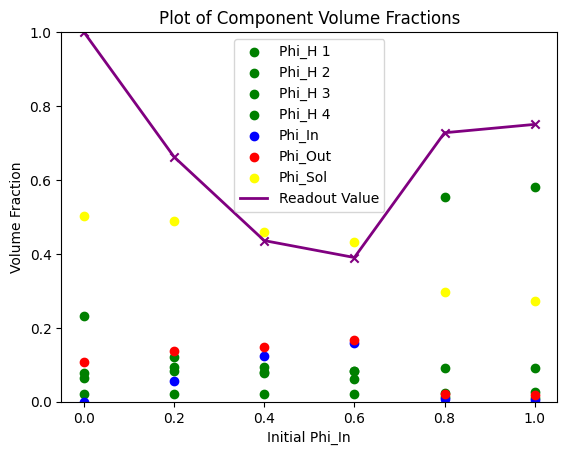

LOSS: 1.6761312885235522
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         7.76544231 5.42900301 7.403494   5.87679407 7.13136199
  0.        ]
 [7.76544231 0.         4.78524563 5.40220032 3.71985143 4.86508386
  0.        ]
 [5.42900301 4.78524563 0.         5.46254322 5.98149926 5.35679397
  0.        ]
 [7.403494   5.40220032 5.46254322 0.         4.02847638 6.7756029
  0.        ]
 [5.87679407 3.71985143 5.98149926 4.02847638 0.         6.62714811
  0.        ]
 [7.13136199 4.86508386 5.35679397 6.7756029  6.62714811 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.08076298 0.11212    0.3053556  0.0837882  0.1
  0.31797322]
 [0.04       0.08076298 0.11212    0.3053556  0.0837882  0.1
  0.27797322]
 [0.08       0.08076298 0.11212    0.3053556  0.0837882  0.1
  0.23797322]
 [0.12       0.08076298 0.11212    0.3053556  0.0837882  0.1
  0.19797322]
 [0.16       0.08076298 0.11212    0.3053556  0.0837882  0.1
  0.15797322]
 [0.

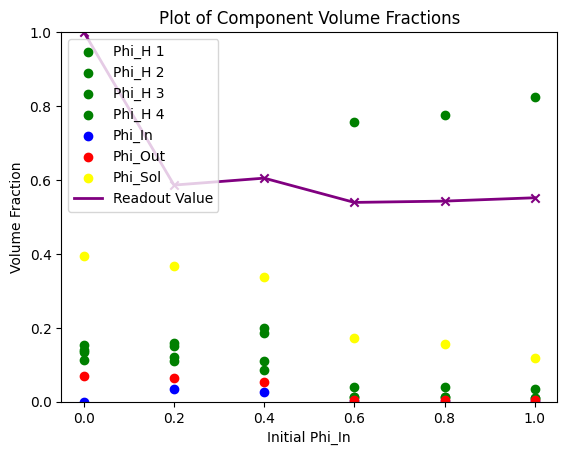

LOSS: 1.2166656803669533
IN BOUNDS
[[0.         5.99311844 5.93149256 5.19195526 5.24955803 5.02014216
  0.        ]
 [5.99311844 0.         4.69226589 7.89607348 5.03457643 5.59487525
  0.        ]
 [5.93149256 4.69226589 0.         6.1028761  5.10351607 5.75257395
  0.        ]
 [5.19195526 7.89607348 6.1028761  0.         5.59163814 6.51078239
  0.        ]
 [5.24955803 5.03457643 5.10351607 5.59163814 0.         7.10394652
  0.        ]
 [5.02014216 5.59487525 5.75257395 6.51078239 7.10394652 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.01659973 0.05061163 0.29182821 0.09312852 0.1
  0.44783191]
 [0.04       0.01659973 0.05061163 0.29182821 0.09312852 0.1
  0.40783191]
 [0.08       0.01659973 0.05061163 0.29182821 0.09312852 0.1
  0.36783191]
 [0.12       0.01659973 0.05061163 0.29182821 0.09312852 0.1
  0.32783191]
 [0.16       0.01659973 0.05061163 0.29182821 0.09312852 0.1
  0.28783191]
 [0.2        0.01659973 0.05061

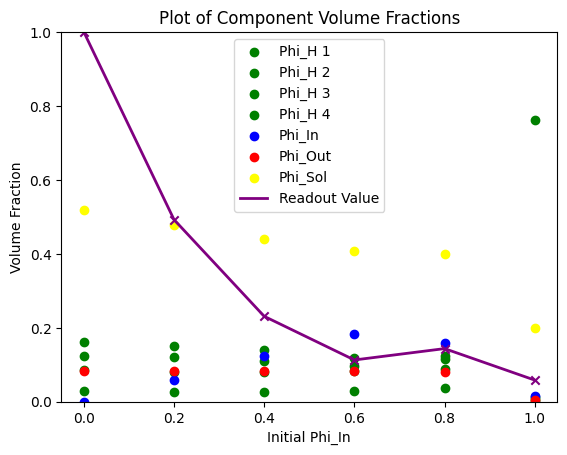

LOSS: 0.8860367168662687
OUT OF BOUNDS
OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[[0.         5.66949657 5.19815126 5.1115959  6.83335524 6.24192572
  0.        ]
 [5.66949657 0.         6.66312106 7.34570091 6.76185014 4.67226757
  0.        ]
 [5.19815126 6.66312106 0.         6.08060514 6.28828342 6.28126343
  0.        ]
 [5.1115959  7.34570091 6.08060514 0.         7.64945325 6.65435218
  0.        ]
 [6.83335524 6.76185014 6.28828342 7.64945325 0.         6.17077974
  0.        ]
 [6.24192572 4.67226757 6.28126343 6.65435218 6.17077974 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.11620497 0.19454983 0.01865799 0.07675018 0.1
  0.49383703]
 [0.04       0.11620497 0.19454983 0.01865799 0.07675018 0.1
  0.45383703]
 [0.08       0.11620497 0.19454983 0.01865799 0.07675018 0.1
  0.41383703]
 [0.12       0.11620497 0.19454983 0.01865799 0.07675018 0.1
  0.37383703]
 [0.16       0.11620497 0.19454983 0.01865799 0.07675018 0.1
  0

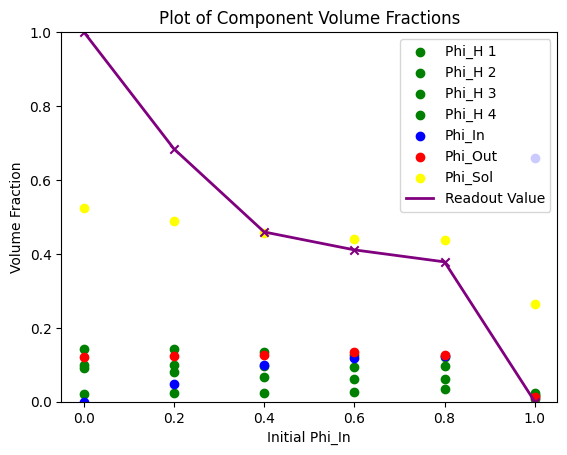

LOSS: 0.7042797761202251
IN BOUNDS
[[0.         5.47349217 4.43926132 4.53788318 7.56896114 6.35641834
  0.        ]
 [5.47349217 0.         6.5526961  5.58952018 6.51821033 5.9537848
  0.        ]
 [4.43926132 6.5526961  0.         5.49195913 6.69945061 5.28533529
  0.        ]
 [4.53788318 5.58952018 5.49195913 0.         5.31840158 5.36710823
  0.        ]
 [7.56896114 6.51821033 6.69945061 5.31840158 0.         4.44584567
  0.        ]
 [6.35641834 5.9537848  5.28533529 5.36710823 4.44584567 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.10083218 0.18363395 0.11943926 0.10663124 0.1
  0.38946338]
 [0.04       0.10083218 0.18363395 0.11943926 0.10663124 0.1
  0.34946338]
 [0.08       0.10083218 0.18363395 0.11943926 0.10663124 0.1
  0.30946338]
 [0.12       0.10083218 0.18363395 0.11943926 0.10663124 0.1
  0.26946338]
 [0.16       0.10083218 0.18363395 0.11943926 0.10663124 0.1
  0.22946338]
 [0.2        0.10083218 0.183633

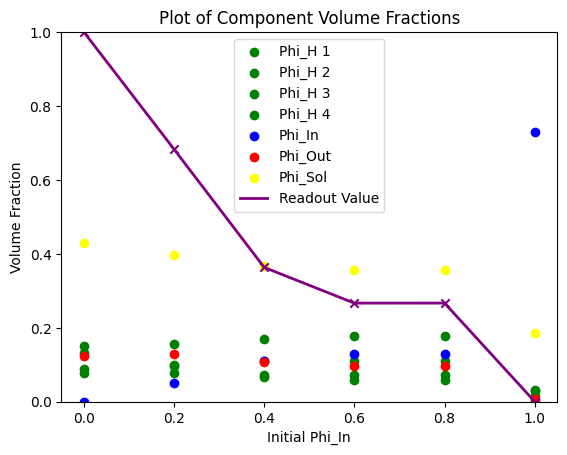

LOSS: 0.648217227499799
IN BOUNDS
[[0.         6.03861279 5.68044829 5.67093724 6.45727345 5.93795959
  0.        ]
 [6.03861279 0.         3.92275915 5.9900145  6.85108801 7.33582772
  0.        ]
 [5.68044829 3.92275915 0.         5.64491363 5.51012783 3.8929902
  0.        ]
 [5.67093724 5.9900145  5.64491363 0.         5.38741771 6.30646521
  0.        ]
 [6.45727345 6.85108801 5.51012783 5.38741771 0.         7.49413326
  0.        ]
 [5.93795959 7.33582772 3.8929902  6.30646521 7.49413326 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.25150798 0.13107143 0.06317167 0.07552275 0.1
  0.37872617]
 [0.04       0.25150798 0.13107143 0.06317167 0.07552275 0.1
  0.33872617]
 [0.08       0.25150798 0.13107143 0.06317167 0.07552275 0.1
  0.29872617]
 [0.12       0.25150798 0.13107143 0.06317167 0.07552275 0.1
  0.25872617]
 [0.16       0.25150798 0.13107143 0.06317167 0.07552275 0.1
  0.21872617]
 [0.2        0.25150798 0.1310714

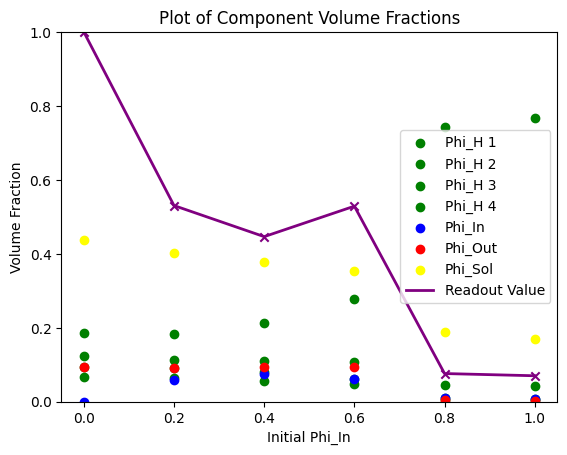

LOSS: 0.8173362601921242
IN BOUNDS
[[0.         4.48317333 7.83654161 6.10191985 5.36051475 5.22355218
  0.        ]
 [4.48317333 0.         5.51181507 5.24225117 5.80884615 6.86339909
  0.        ]
 [7.83654161 5.51181507 0.         5.62538214 7.1954001  5.994777
  0.        ]
 [6.10191985 5.24225117 5.62538214 0.         4.86288721 5.08773076
  0.        ]
 [5.36051475 5.80884615 7.1954001  4.86288721 0.         6.45635953
  0.        ]
 [5.22355218 6.86339909 5.994777   5.08773076 6.45635953 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.12699556 0.11707278 0.13344853 0.16364753 0.1
  0.3588356 ]
 [0.04       0.12699556 0.11707278 0.13344853 0.16364753 0.1
  0.3188356 ]
 [0.08       0.12699556 0.11707278 0.13344853 0.16364753 0.1
  0.2788356 ]
 [0.12       0.12699556 0.11707278 0.13344853 0.16364753 0.1
  0.2388356 ]
 [0.16       0.12699556 0.11707278 0.13344853 0.16364753 0.1
  0.1988356 ]
 [0.2        0.12699556 0.1170727

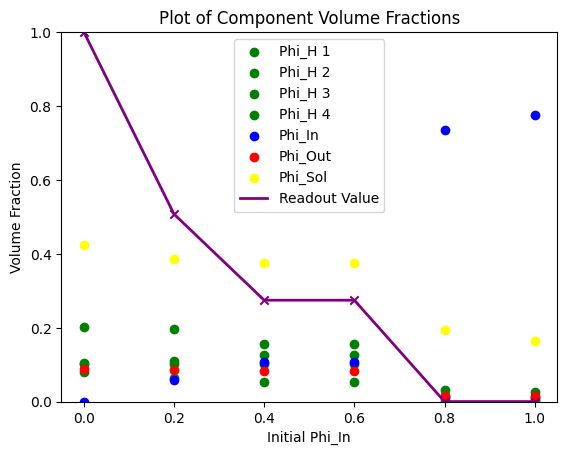

LOSS: 0.8447241316600959
IN BOUNDS
[[0.         6.424169   6.54022039 6.71122948 5.38960978 6.10284989
  0.        ]
 [6.424169   0.         7.12482679 4.78242266 6.68189295 6.01181686
  0.        ]
 [6.54022039 7.12482679 0.         4.87511636 5.83551457 6.92677883
  0.        ]
 [6.71122948 4.78242266 4.87511636 0.         8.66196101 6.41254049
  0.        ]
 [5.38960978 6.68189295 5.83551457 8.66196101 0.         5.75727794
  0.        ]
 [6.10284989 6.01181686 6.92677883 6.41254049 5.75727794 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.01659973 0.25209402 0.04883408 0.10451057 0.1
  0.4779616 ]
 [0.04       0.01659973 0.25209402 0.04883408 0.10451057 0.1
  0.4379616 ]
 [0.08       0.01659973 0.25209402 0.04883408 0.10451057 0.1
  0.3979616 ]
 [0.12       0.01659973 0.25209402 0.04883408 0.10451057 0.1
  0.3579616 ]
 [0.16       0.01659973 0.25209402 0.04883408 0.10451057 0.1
  0.3179616 ]
 [0.2        0.01659973 0.25209

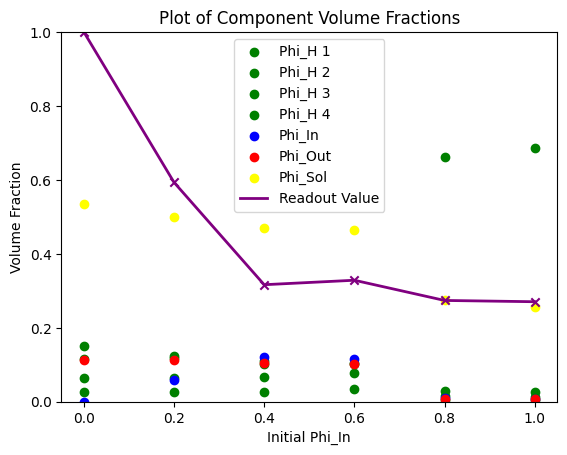

LOSS: 0.8887047143777757
IN BOUNDS
[[0.         7.32057059 6.41101372 5.40265979 5.28984924 5.39152478
  0.        ]
 [7.32057059 0.         6.44823804 4.87262692 6.2121804  6.56464929
  0.        ]
 [6.41101372 6.44823804 0.         5.71716613 7.69214294 5.4264018
  0.        ]
 [5.40265979 4.87262692 5.71716613 0.         6.902671   4.38531048
  0.        ]
 [5.28984924 6.2121804  7.69214294 6.902671   0.         6.29372698
  0.        ]
 [5.39152478 6.56464929 5.4264018  4.38531048 6.29372698 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.12554095 0.30606125 0.06625435 0.05069517 0.1
  0.35144828]
 [0.04       0.12554095 0.30606125 0.06625435 0.05069517 0.1
  0.31144828]
 [0.08       0.12554095 0.30606125 0.06625435 0.05069517 0.1
  0.27144828]
 [0.12       0.12554095 0.30606125 0.06625435 0.05069517 0.1
  0.23144828]
 [0.16       0.12554095 0.30606125 0.06625435 0.05069517 0.1
  0.19144828]
 [0.2        0.12554095 0.306061

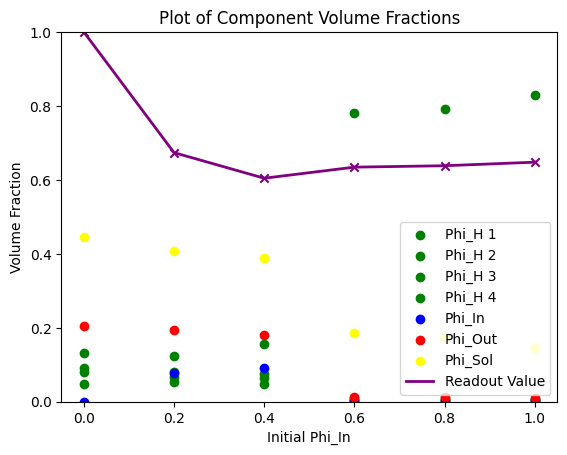

LOSS: 1.4921833528437998
IN BOUNDS
[[0.         6.30282109 6.77362962 4.73681401 5.78741428 4.95754321
  0.        ]
 [6.30282109 0.         5.19144239 7.08633531 4.19729251 4.78785769
  0.        ]
 [6.77362962 5.19144239 0.         7.09441986 5.15945379 7.60157635
  0.        ]
 [4.73681401 7.08633531 7.09441986 0.         4.59392727 5.86182817
  0.        ]
 [5.78741428 4.19729251 5.15945379 4.59392727 0.         6.06689836
  0.        ]
 [4.95754321 4.78785769 7.60157635 5.86182817 6.06689836 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.24406146 0.04276988 0.10201899 0.16044664 0.1
  0.35070303]
 [0.04       0.24406146 0.04276988 0.10201899 0.16044664 0.1
  0.31070303]
 [0.08       0.24406146 0.04276988 0.10201899 0.16044664 0.1
  0.27070303]
 [0.12       0.24406146 0.04276988 0.10201899 0.16044664 0.1
  0.23070303]
 [0.16       0.24406146 0.04276988 0.10201899 0.16044664 0.1
  0.19070303]
 [0.2        0.24406146 0.04276

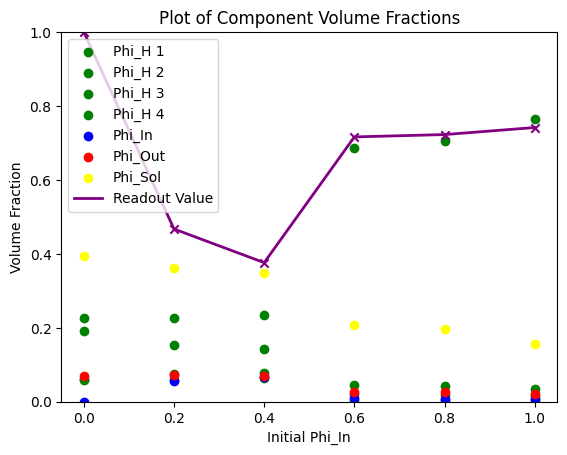

LOSS: 2.2581561359410216
IN BOUNDS
[[0.         6.27133563 7.03869091 6.38462913 5.73971019 4.19648447
  0.        ]
 [6.27133563 0.         4.79335801 7.45980277 6.33404094 4.85589834
  0.        ]
 [7.03869091 4.79335801 0.         6.29553165 6.93706384 5.87365697
  0.        ]
 [6.38462913 7.45980277 6.29553165 0.         6.30428099 5.73876906
  0.        ]
 [5.73971019 6.33404094 6.93706384 6.30428099 0.         7.63072108
  0.        ]
 [4.19648447 4.85589834 5.87365697 5.73876906 7.63072108 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.35600702]
 [0.04       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.31600702]
 [0.08       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.27600702]
 [0.12       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.23600702]
 [0.16       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.19600702]
 [0.2        0.1225779  0.29137

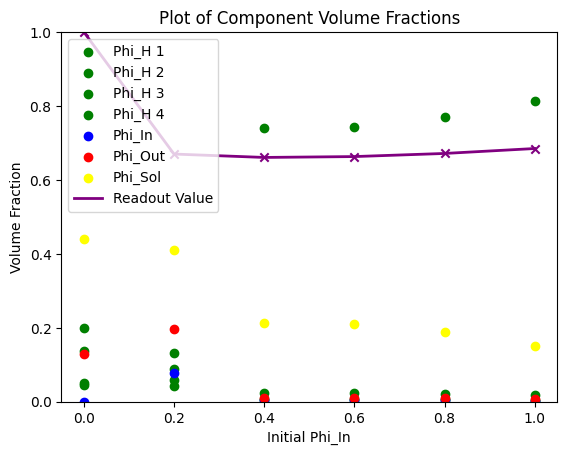

LOSS: 1.5832527241580963
IN BOUNDS
[[0.         5.7351669  8.0037453  4.65579343 4.91591605 6.573845
  0.        ]
 [5.7351669  0.         6.87682257 5.70414152 7.40809984 4.92732248
  0.        ]
 [8.0037453  6.87682257 0.         6.53174106 5.6049851  5.04013283
  0.        ]
 [4.65579343 5.70414152 6.53174106 0.         6.67796178 5.34074569
  0.        ]
 [4.91591605 7.40809984 5.6049851  6.67796178 0.         6.52686181
  0.        ]
 [6.573845   4.92732248 5.04013283 5.34074569 6.52686181 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.08169418 0.11676145 0.16063323 0.0791598  0.1
  0.46175133]
 [0.04       0.08169418 0.11676145 0.16063323 0.0791598  0.1
  0.42175133]
 [0.08       0.08169418 0.11676145 0.16063323 0.0791598  0.1
  0.38175133]
 [0.12       0.08169418 0.11676145 0.16063323 0.0791598  0.1
  0.34175133]
 [0.16       0.08169418 0.11676145 0.16063323 0.0791598  0.1
  0.30175133]
 [0.2        0.08169418 0.1167614

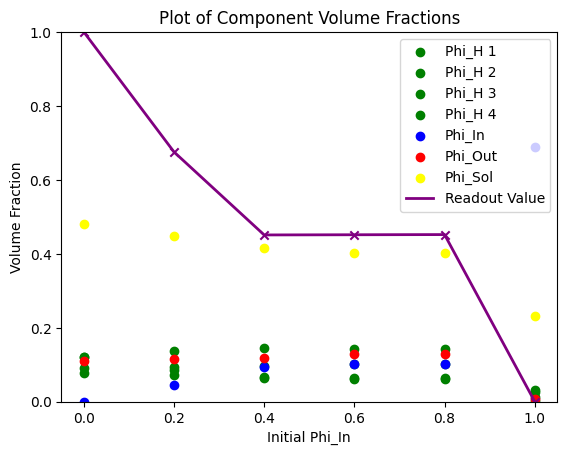

LOSS: 0.8147809436939326
IN BOUNDS
[[0.         4.86797312 5.73449712 4.49978939 5.29723709 5.41714683
  0.        ]
 [4.86797312 0.         6.75847864 7.47210888 4.32855639 4.99351995
  0.        ]
 [5.73449712 6.75847864 0.         6.04566552 4.02266965 5.3463306
  0.        ]
 [4.49978939 7.47210888 6.04566552 0.         6.18090139 4.01461038
  0.        ]
 [5.29723709 4.32855639 4.02266965 6.18090139 0.         5.64068504
  0.        ]
 [5.41714683 4.99351995 5.3463306  4.01461038 5.64068504 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.35600702]
 [0.04       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.31600702]
 [0.08       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.27600702]
 [0.12       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.23600702]
 [0.16       0.1225779  0.29137989 0.07263223 0.05740297 0.1
  0.19600702]
 [0.2        0.1225779  0.291379

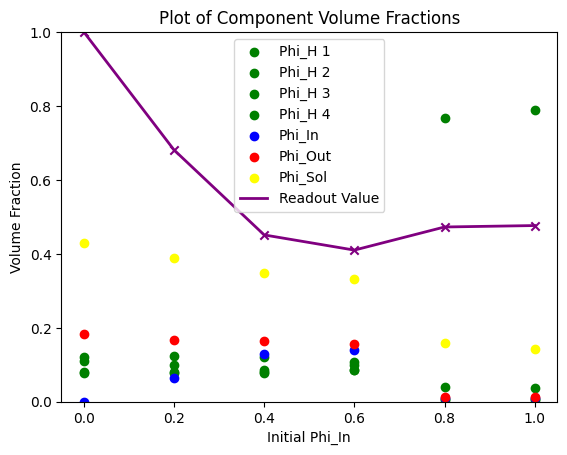

LOSS: 1.0212663228116887
IN BOUNDS
[[0.         5.89263702 6.1421591  5.53821649 5.90138025 7.37042582
  0.        ]
 [5.89263702 0.         6.53438712 6.83433693 7.4071245  4.87565789
  0.        ]
 [6.1421591  6.53438712 0.         6.587991   6.72389415 6.19819459
  0.        ]
 [5.53821649 6.83433693 6.587991   0.         4.98135646 6.11694641
  0.        ]
 [5.90138025 7.4071245  6.72389415 4.98135646 0.         4.67025836
  0.        ]
 [7.37042582 4.87565789 6.19819459 6.11694641 4.67025836 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.08169418 0.0888088  0.16063323 0.1499561  0.1
  0.41890769]
 [0.04       0.08169418 0.0888088  0.16063323 0.1499561  0.1
  0.37890769]
 [0.08       0.08169418 0.0888088  0.16063323 0.1499561  0.1
  0.33890769]
 [0.12       0.08169418 0.0888088  0.16063323 0.1499561  0.1
  0.29890769]
 [0.16       0.08169418 0.0888088  0.16063323 0.1499561  0.1
  0.25890769]
 [0.2        0.08169418 0.08880

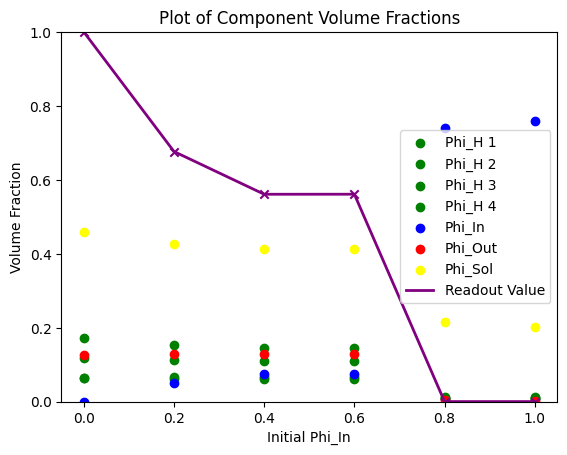

LOSS: 0.612202040260367
IN BOUNDS
[[0.         5.80751073 6.65087153 6.20211866 6.51135464 7.3964475
  0.        ]
 [5.80751073 0.         6.9761547  8.17570579 3.64175314 6.21344276
  0.        ]
 [6.65087153 6.9761547  0.         5.4039783  6.19623468 6.95210953
  0.        ]
 [6.20211866 8.17570579 5.4039783  0.         7.09898322 4.79117468
  0.        ]
 [6.51135464 3.64175314 6.19623468 7.09898322 0.         6.83068434
  0.        ]
 [7.3964475  6.21344276 6.95210953 4.79117468 6.83068434 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.11932753 0.14525907 0.10241416 0.14820746 0.1
  0.38479178]
 [0.04       0.11932753 0.14525907 0.10241416 0.14820746 0.1
  0.34479178]
 [0.08       0.11932753 0.14525907 0.10241416 0.14820746 0.1
  0.30479178]
 [0.12       0.11932753 0.14525907 0.10241416 0.14820746 0.1
  0.26479178]
 [0.16       0.11932753 0.14525907 0.10241416 0.14820746 0.1
  0.22479178]
 [0.2        0.11932753 0.1452590

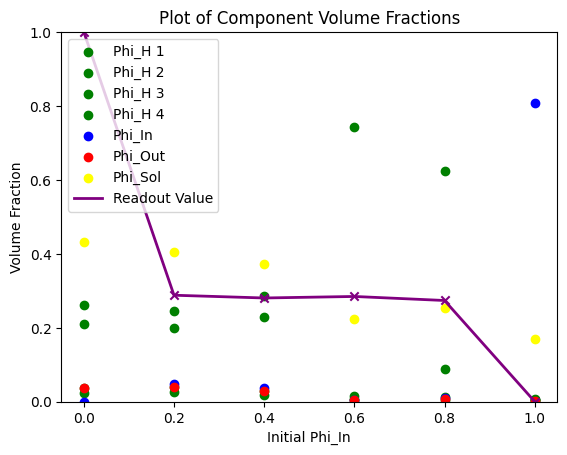

LOSS: 1.1809577600045549
IN BOUNDS
[[0.         6.17433925 4.17749282 5.81516009 7.56599833 3.62909668
  0.        ]
 [6.17433925 0.         5.21724604 4.83605876 5.36077979 5.77332051
  0.        ]
 [4.17749282 5.21724604 0.         6.33642884 7.18319364 5.88328396
  0.        ]
 [5.81516009 4.83605876 6.33642884 0.         5.90546062 5.3714042
  0.        ]
 [7.56599833 5.36077979 7.18319364 5.90546062 0.         7.09224509
  0.        ]
 [3.62909668 5.77332051 5.88328396 5.3714042  7.09224509 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.16985363 0.05061163 0.12700012 0.18884713 0.1
  0.36368749]
 [0.04       0.16985363 0.05061163 0.12700012 0.18884713 0.1
  0.32368749]
 [0.08       0.16985363 0.05061163 0.12700012 0.18884713 0.1
  0.28368749]
 [0.12       0.16985363 0.05061163 0.12700012 0.18884713 0.1
  0.24368749]
 [0.16       0.16985363 0.05061163 0.12700012 0.18884713 0.1
  0.20368749]
 [0.2        0.16985363 0.050611

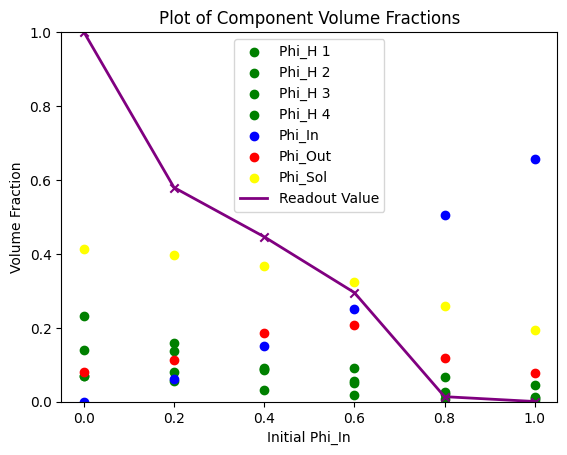

LOSS: 0.5712627621309809
OUT OF BOUNDS
IN BOUNDS
[[0.         5.06698006 5.21448399 5.32826991 3.88075598 5.29770757
  0.        ]
 [5.06698006 0.         4.31438462 6.75534302 5.47073151 5.53747751
  0.        ]
 [5.21448399 4.31438462 0.         6.62118924 4.55038671 6.35073748
  0.        ]
 [5.32826991 6.75534302 6.62118924 0.         6.50280937 5.1388448
  0.        ]
 [3.88075598 5.47073151 4.55038671 6.50280937 0.         6.35640603
  0.        ]
 [5.29770757 5.53747751 6.35073748 5.1388448  6.35640603 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.15192271 0.0468199  0.16559589 0.2294394  0.1
  0.3062221 ]
 [0.04       0.15192271 0.0468199  0.16559589 0.2294394  0.1
  0.2662221 ]
 [0.08       0.15192271 0.0468199  0.16559589 0.2294394  0.1
  0.2262221 ]
 [0.12       0.15192271 0.0468199  0.16559589 0.2294394  0.1
  0.1862221 ]
 [0.16       0.15192271 0.0468199  0.16559589 0.2294394  0.1
  0.1462221 ]
 [0.2        0.151

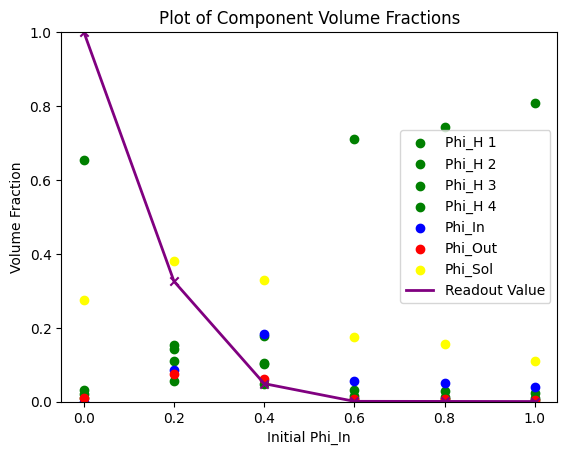

LOSS: 1.360491489813471
IN BOUNDS
[[0.         5.67766982 5.46904515 5.27796744 5.27654293 5.50876245
  0.        ]
 [5.67766982 0.         7.30845064 5.91878518 6.57806074 6.79871806
  0.        ]
 [5.46904515 7.30845064 0.         5.66593416 5.98526337 5.80975044
  0.        ]
 [5.27796744 5.91878518 5.66593416 0.         6.58209644 5.66235845
  0.        ]
 [5.27654293 6.57806074 5.98526337 6.58209644 0.         5.02509096
  0.        ]
 [5.50876245 6.79871806 5.80975044 5.66235845 5.02509096 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]
[[0.         0.20748698 0.10706191 0.06878105 0.05740297 0.1
  0.4592671 ]
 [0.04       0.20748698 0.10706191 0.06878105 0.05740297 0.1
  0.4192671 ]
 [0.08       0.20748698 0.10706191 0.06878105 0.05740297 0.1
  0.3792671 ]
 [0.12       0.20748698 0.10706191 0.06878105 0.05740297 0.1
  0.3392671 ]
 [0.16       0.20748698 0.10706191 0.06878105 0.05740297 0.1
  0.2992671 ]
 [0.2        0.20748698 0.107061

In [ ]:

bounds = [[0,0.4], [0,0.4], [0,0.4],[0,0.4]]
result_DE = differential_evolution(evolve_components_flory_loss,bounds = bounds, maxiter = 5, popsize = 2)